<a href="https://colab.research.google.com/github/Fragoa/Image-Coloring-with-AE-and-VAE/blob/main/ImageColoring_AE_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import zipfile
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import requests

In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2025-05-27 06:05:04--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-05-27 06:05:04--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  45.1MB/s    in 6.1s    

2025-05-27 06:05:10 (39.0 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [3]:
data_dir = './tiny-imagenet-200/train'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = ImageFolder(root=data_dir, transform=transform)

indices = random.sample(range(len(dataset)), 10)
subset = Subset(dataset, indices)

In [5]:
grayscale_images = []
rgb_images = []

for img, _ in subset:
    rgb_images.append(img)
    gray = transforms.functional.rgb_to_grayscale(img, num_output_channels=1)
    grayscale_images.append(gray)

grayscale_images = torch.stack(grayscale_images)
rgb_images = torch.stack(rgb_images)

dataset_size = len(grayscale_images)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_gray, val_gray, test_gray = torch.split(grayscale_images, [train_size, val_size, test_size])
train_rgb, val_rgb, test_rgb = torch.split(rgb_images, [train_size, val_size, test_size])

Total images: 10
Resolution: torch.Size([128, 128])
Train/Val/Test: 7/1/2


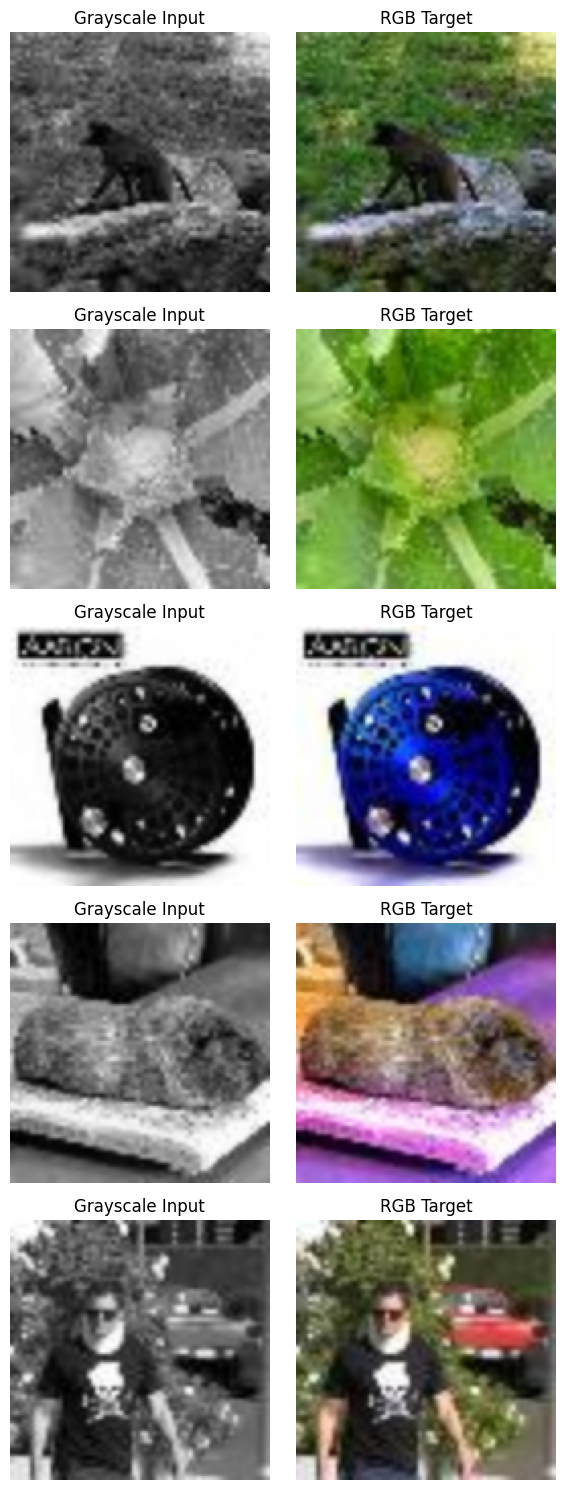

In [6]:
print(f'Total images: {dataset_size}')
print(f'Resolution: {grayscale_images[0].shape[1:]}')
print(f'Train/Val/Test: {len(train_gray)}/{len(val_gray)}/{len(test_gray)}')

def show_samples(gray_imgs, rgb_imgs, n=5):
    fig, axs = plt.subplots(n, 2, figsize=(6, n*3))
    for i in range(n):
        axs[i, 0].imshow(gray_imgs[i][0], cmap='gray')
        axs[i, 0].set_title('Grayscale Input')
        axs[i, 1].imshow(rgb_imgs[i].permute(1, 2, 0))
        axs[i, 1].set_title('RGB Target')
        for j in range(2):
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_gray, train_rgb, n=5)

In [8]:
class ColorizationAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(ColorizationAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 8x8
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256*8*8, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 256*8*8)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     # 128x128
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.decoder(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationAE().to(device)
print(model)

ColorizationAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(256, 8, 8))
    (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3,

In [12]:
batch_size = 32
lr = 1e-3
epochs = 50

train_ds = TensorDataset(train_gray, train_rgb)
val_ds = TensorDataset(val_gray, val_rgb)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

In [13]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            val_loss += loss.item()

In [14]:
train_losses.append(train_loss / len(train_dl))
val_losses.append(val_loss / len(val_dl))
print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}')

Epoch 50: Train Loss=0.0352, Val Loss=0.0536


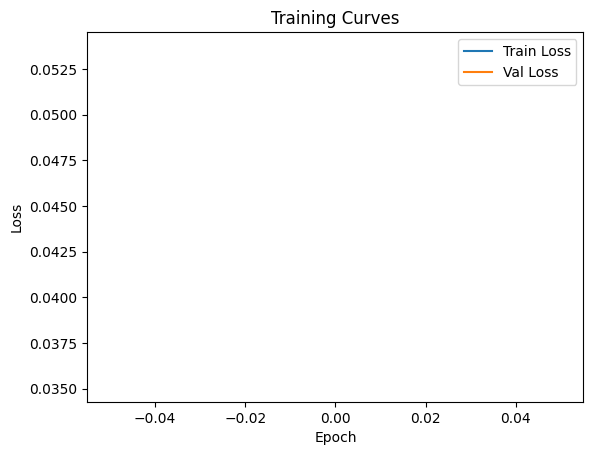

In [15]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curves')
plt.show()

In [16]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_absolute_error

test_ds = TensorDataset(test_gray, test_rgb)
test_dl = DataLoader(test_ds, batch_size=1)

model.eval()
psnr_list, ssim_list, mae_list = [], [], []

def evaluate_sample(x, y_true):
    y_pred = model(x.to(device)).cpu().squeeze().detach()
    y_true = y_true.squeeze()
    y_pred_np = y_pred.permute(1, 2, 0).numpy()
    y_true_np = y_true.permute(1, 2, 0).numpy()

    p = psnr(y_true_np, y_pred_np, data_range=1.0)
    s = ssim(y_true_np, y_pred_np, channel_axis=-1, data_range=1.0)
    m = mean_absolute_error(y_true_np.flatten(), y_pred_np.flatten())
    return p, s, m, y_pred_np

samples = []
for x, y in test_dl:
    p, s, m, pred_img = evaluate_sample(x, y)
    psnr_list.append(p)
    ssim_list.append(s)
    mae_list.append(m)
    if len(samples) < 5:
        samples.append((x.squeeze()[0].numpy(), pred_img, y.squeeze().permute(1,2,0).numpy()))

print(f'PSNR: {np.mean(psnr_list):.4f}, SSIM: {np.mean(ssim_list):.4f}, MAE: {np.mean(mae_list):.4f}')


PSNR: 11.2265, SSIM: 0.1547, MAE: 0.2243


ValueError: cannot reshape array of size 128 into shape (128,128)

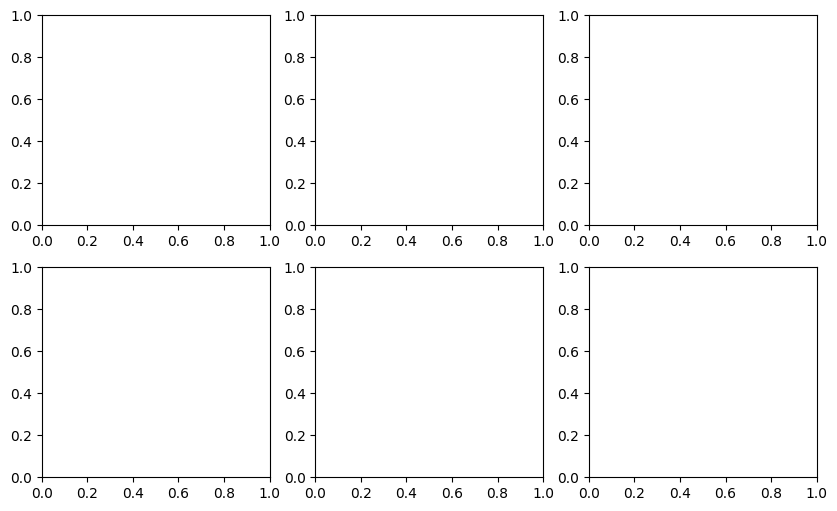

In [18]:
def show_results(samples):
    fig, axs = plt.subplots(len(samples), 3, figsize=(10, len(samples)*3))
    for i, (gray, pred, true) in enumerate(samples):
        if gray.ndim == 1:
            gray = gray.reshape(128, 128)
        axs[i, 0].imshow(gray, cmap='gray')
        axs[i, 0].set_title('Input Grayscale')
        axs[i, 1].imshow(pred)
        axs[i, 1].set_title('Predicted RGB')
        axs[i, 2].imshow(true)
        axs[i, 2].set_title('Ground Truth RGB')
        for j in range(3):
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()


show_results(samples)
